In [1]:
import time
import os
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras

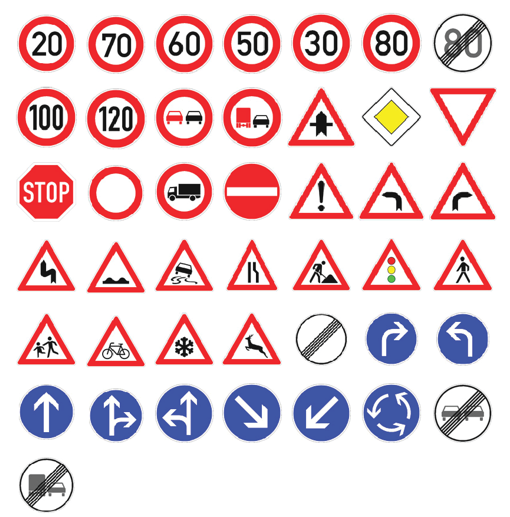

## 1. 데이터 로드와 전처리

In [ ]:
!wget gtsrb.zip https://www.dropbox.com/s/5uc83j3aky5b9cv/gtsrb.zip

In [4]:
try:
     os.makedirs('/content/trafficSign')
except:
  pass

os.chdir('/content/trafficSign')
try:
    os.makedirs('gtsrb')
except:
    pass


In [5]:
!unzip -q /content/gtsrb.zip -d /content/trafficSign/gtsrb

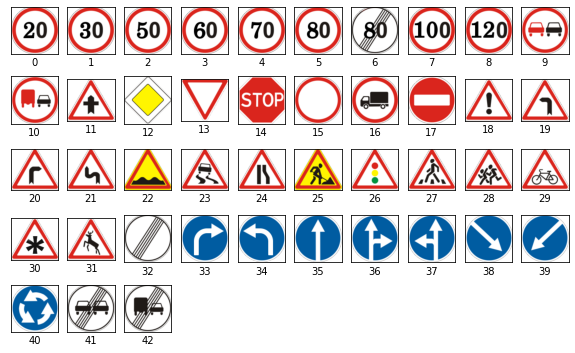

In [6]:
# 각 클래스별 정보 확인
dir = './gtsrb'
    
plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(8,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = dir + "/Meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

In [7]:
#dictionary to label all traffic signs class.
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

1.  각 클래스별 폴더에 들어가 image 파일 네임 리스트인 **`images`** 생성
2.  images 를 for 문을 돌면서 각 이미지의 크기를 조정한 후에 **`image_data`** 리스트에 첨부하고 클래스 라벨은 **`image_labels`** 에 첨부
3. **`image_data`** 와 **`image_labels`** 를 numpy array로 변환



In [8]:
NUM_CLASSES = 43
H = 64
W = 64

image_data = []
image_labels = []

# 실습 코드 작성
for i in range(NUM_CLASSES):
    path = './gtsrb/Train/' + str(i)
    images = os.listdir(path)
    
    for img in images:
        try:
            image = cv2.imread(path + '/' + img) 
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((H, W))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error - Image loading")
    
# 리스트를 numpy array로 변환
image_data = np.array(image_data)
image_labels = np.array(image_labels)

In [9]:
image_data.shape

(39209, 64, 64, 3)

1.  [**`np.random.shuffle`**](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html) 을 활용하여 이미지의 인덱스를 골고루 섞어줌
2. [**`train_test_split`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) 함수를 활용하여 학습/검증/시험 데이터, 학습/검증/시험험 라벨 분리, 각각 **`X_train`**/**`X_valid`**/**`X_test`**, **`y_train`**/**`y_valid`**/**`y_test`**

3.  **`X_train`**, **`X_valid`** 를 255로 나누어 0~1 범위로 변환


In [10]:
from sklearn.model_selection import train_test_split

# 실습 코드 작성
# 데이터셋 셔플
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# 학습/검증/시험 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(image_data, image_labels, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

# 정규화
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

In [11]:
print("X_train.shape", X_train.shape, "\t X_valid.shape", X_valid.shape, "\t X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape, "\t\t\t y_valid.shape", y_valid.shape, "\t\t\t y_test.shape", y_test.shape)

X_train.shape (23525, 64, 64, 3) 	 X_valid.shape (7842, 64, 64, 3) 	 X_test.shape (7842, 64, 64, 3)
y_train.shape (23525,) 			 y_valid.shape (7842,) 			 y_test.shape (7842,)


## 2. VGG16 기반 모델 생성 및 학습

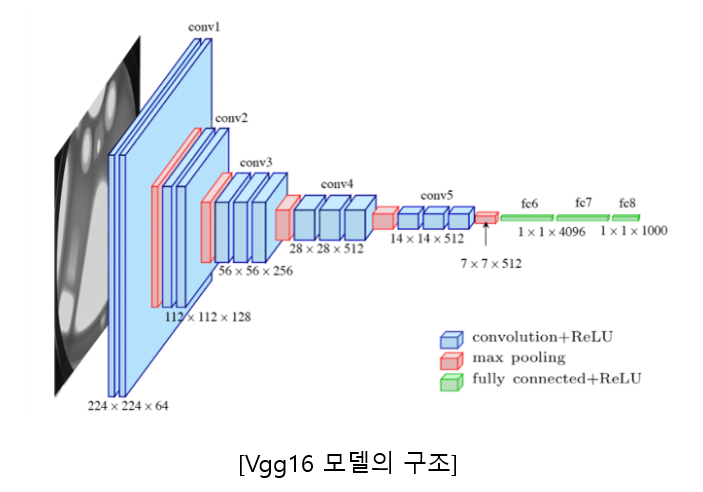

1.  [**`VGG16`**](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16?hl=hi) api를 활용하여 **`input_shape=(64,64,3)`**, **`weight='imagenet'`**, **`include_top=False`** 조건을 활용하여 기반 모델 불러오기
2. vgg16 기반 모델의 각 층을 **`vgg16.layers`** 로 불러와 각 층의 **`trainable`** 상태를 **`False`** 로 변환

3.  기반 모델에 Flatten 레이어와 Dense 레이어 추가
4.  optimizer와 loss를 지정해주며  model 컴파일
5.  20 epoch 동안 학습 진행



In [12]:
# vgg16 모델 불러오기
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(input_shape=(64, 64, 3), weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [13]:
# 이미 학습된 층을 더이상 학습하지 않음
for layer in vgg16.layers:
    layer.trainable = False

In [14]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, Dropout, BatchNormalization

add_model = Sequential()
add_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
add_model.add(Dense(1024, activation='relu'))
add_model.add(Dense(NUM_CLASSES, activation='softmax'))

model = Model(inputs=vgg16.inputs, outputs=add_model(vgg16.outputs))

# optimizer, loss, metric을 활용하여 compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [15]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
184/184 [==============================] - 25s 85ms/step - loss: 1.3902 - accuracy: 0.5900 - val_loss: 0.8771 - val_accuracy: 0.7355
Epoch 2/20
184/184 [==============================] - 13s 72ms/step - loss: 0.6781 - accuracy: 0.7975 - val_loss: 0.5929 - val_accuracy: 0.8275
Epoch 3/20
184/184 [==============================] - 14s 74ms/step - loss: 0.4679 - accuracy: 0.8651 - val_loss: 0.5005 - val_accuracy: 0.8460
Epoch 4/20
184/184 [==============================] - 13s 72ms/step - loss: 0.3499 - accuracy: 0.8966 - val_loss: 0.3859 - val_accuracy: 0.8834
Epoch 5/20
184/184 [==============================] - 13s 71ms/step - loss: 0.2772 - accuracy: 0.9208 - val_loss: 0.4012 - val_accuracy: 0.8732
Epoch 6/20
184/184 [==============================] - 13s 70ms/step - loss: 0.2247 - accuracy: 0.9330 - val_loss: 0.3010 - val_accuracy: 0.9045
Epoch 7/20
184/184 [==============================] - 13s 71ms/step - loss: 0.1743 - accuracy: 0.9524 - val_loss: 0.3041 - val_accuracy:

## 3. 학습 결과 시각화

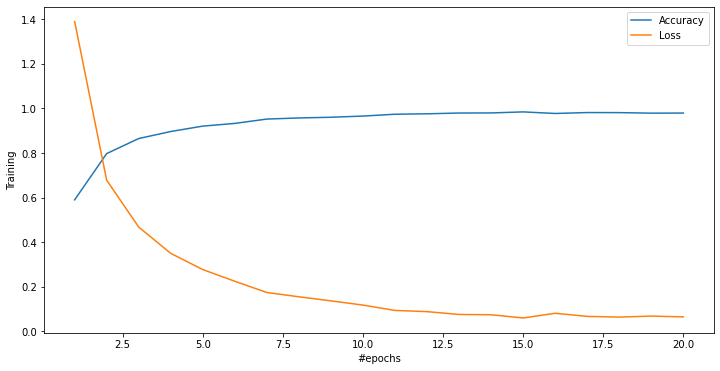

In [16]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 1+q), history.history['accuracy'], label = 'Accuracy')
plt.plot(range(1, 1+q), history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

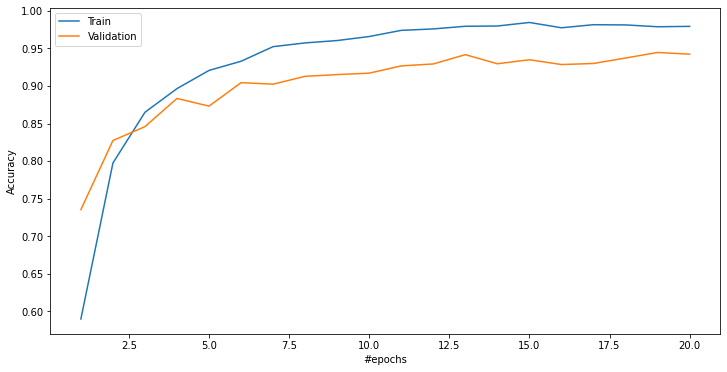

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 1+q), history.history['accuracy'], label = 'Train')
plt.plot(range(1, 1+q), history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

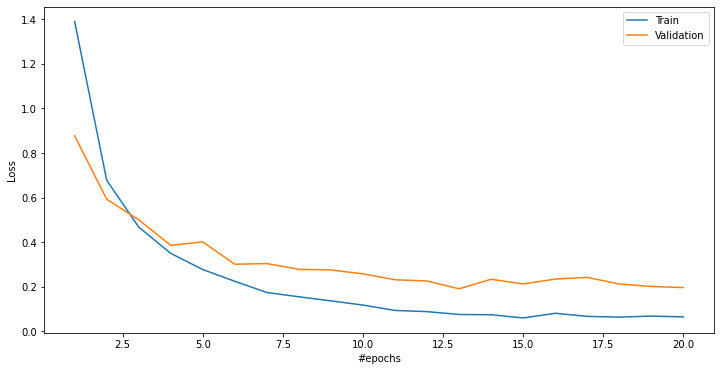

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 1+q), history.history['loss'], label = 'Train')
plt.plot(range(1, 1+q), history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

In [19]:
model.evaluate(X_test, y_test)

246/246 [==============================] - 5s 19ms/step - loss: 0.1827 - accuracy: 0.9466


[0.18265536427497864, 0.9465697407722473]